In [ ]:
!pip3 install requests skimpy csaps shap pygam numpy==1.23.5

In [ ]:
!pip3 install lightgbm catboost

In [ ]:
!git clone https://github.com/ustunb/risk-slim
!pip install -e ./risk-slim 		# install in editable mode  

In [1]:
import requests
def githubimport(user, repo, module):
   d = {}
   url = 'https://raw.githubusercontent.com/{}/{}/master/{}.py'.format(user, repo, module)
   r = requests.get(url).text
   exec(r, d)
   return d

# get repository

medical_explainer = githubimport('giangntgg', 'Uni-ACS', 'medical_explainer')
medical_explainer_classic = githubimport('giangntgg', 'Uni-ACS', 'medical_explainer_classic')

In [14]:
import pandas as pd 
from skimpy import skim

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

import riskslim

from sklearn.model_selection import GridSearchCV
from sklearn.inspection import PartialDependenceDisplay

#Summary of the paper 

Clinical scores are the most popularly used metrics to stratify clinical outcomes and risks for patients. The classical clinical score is aggregated via a logistic regression model using several manually selected features. On the other hand, clinical models utilising machine learning could predict patients outcome with much higher power, but they are not as interpretable and do not translate to a single score like the classical clinical score. 

The paper aimed to translate clinical machine learning model predictions (such as predictions of heart failures, kidney failures and sepsis during surgery) to an interpretable and risk stratifying clinical score – an equivalent yet possibly more powerful score compared to the classical clinical score. 

The approach taken by the paper Unified Auto Clinical Scoring (“Uni-ACS”) was to use SHapley Additive exPlanations (SHAP) – a popular model interpretability method – that was able to solve the following issues of the classical risk score aggregation.

###Claims to verify 
* Uni-ACS approach have higher predictive power compared to Risk SLIM and baseline classical clinical scores across the dataset chosen.

* Machine learning and logistic regression performance dropped after converting to a clinical score. 

* The converted clinical score is correlated to the explanation of feature relationships to output in the ML models. 


#Descriptive Analysis

In [3]:
path = 'https://raw.githubusercontent.com/giangntgg/Uni-ACS/main/mimiciii_sepsis/mimiciii_sepsis.csv'

df = pd.read_csv(path)

In [4]:
df.head()

,Unnamed: 0,SUBJECT_ID,HADM_ID,Age,Gender,LOS,28 Day Death,In Hospital Death,Hypertension,Hyperlipidemia,...,Gram Positive,Gram Negative,Yeast,Contaminant,Other Pathogen,antibiotics,antivirals,antifungals,inotropes,immunosuppresant
0,0,689,129080,54.258727,F,7.919444,0,0,1.0,0.0,...,9,0,0,0,0,4,0,0,1,0
1,1,720,100753,51.690623,F,17.184722,0,0,0.0,0.0,...,0,0,0,0,0,2,0,0,1,2
2,2,736,164142,35.011636,F,7.693056,0,0,1.0,0.0,...,0,0,0,0,0,5,0,0,0,2
3,3,788,139716,71.488022,F,4.737500,0,0,0.0,0.0,...,0,0,0,0,0,2,0,0,0,0
4,4,64,172056,26.680356,F,15.150000,0,0,1.0,0.0,...,0,0,0,0,0,6,0,1,0,0


In [31]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 4555   │ │ float64     │ 100   │                                                          │
│ │ Number of columns │ 118    │ │ int64       │ 17    │                                                          │
│ └───────────────────┴────────┘ │ string      │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name             ┃ NA    ┃ NA %   ┃ mean    ┃ sd     ┃ p0      ┃ p25     ┃ p75    ┃ p100   ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩  │
│ │ Unnamed: 0              │     0 │      0 │    2300 │   1300 │       0 │    1100 │   3400 │   4600 │ ██████ │  │
│ │ SUBJECT_ID              │     0 │      0 │   41000 │  30000 │      21 │   16000 │  66000 │ 100000 │ ██▂▄▃▄ │  │
│ │ HADM_ID                 │     0 │      0 │  150000 │  29000 │  100000 │  130000 │ 170000 │ 200000 │ ███▇█▇ │  │
│ │ Age                     │     0 │      0 │      67 │     16 │      18 │      56 │     80 │     90 │ ▁▁▄▆▆█ │  │
│ │ LOS                     │     0 │      0 │      15 │     17 │   -0.32 │     5.5 │     19 │    290 │   █    │  │
│ │ 28 Day Death            │     0 │      0 │    0.38 │   0.49 │       0 │       0 │      1 │      1 │ █    ▅ │  │
│ │ In Hospital Death       │     0 │      0 │    0.32 │   0.47 │       0 │       0 │      1 │      1 │ █    ▄ │  │
│ │ Hypertension            │   120 │    2.7 │    0.37 │   0.48 │       0 │       0 │      1 │      1 │ █    ▅ │  │
│ │ Hyperlipidemia          │   120 │    2.7 │    0.04 │    0.2 │       0 │       0 │      0 │      1 │   █    │  │
│ │ Diabetes                │   120 │    2.7 │   0.065 │   0.25 │       0 │       0 │      0 │      1 │ █    ▁ │  │
│ │ Hematocrit              │     6 │   0.13 │      34 │    6.4 │     9.9 │      30 │     38 │     64 │   ▂█▄  │  │
│ │ Hematocrit, Calculat    │  2700 │     58 │      31 │    6.7 │       0 │      27 │     35 │     60 │   ▇█▂  │  │
│ │ Hemoglobin              │     7 │   0.15 │      11 │    2.2 │       0 │     9.7 │     13 │     22 │   ▇█▁  │  │
│ │ Red Blood Cells         │    10 │   0.22 │     3.7 │   0.76 │    0.97 │     3.2 │    4.2 │      7 │  ▂█▅▁  │  │
│ │ Nucleated Red Cells     │  3700 │     80 │     4.1 │     14 │       0 │       1 │      3 │    280 │   █    │  │
│ │ RDW                     │     9 │    0.2 │      16 │    2.4 │      12 │      14 │     17 │     30 │  ▇█▂▁  │  │
│ │ MCH                     │    10 │   0.22 │      30 │      3 │      16 │      29 │     32 │     46 │   ▁█▅  │  │
│ │ MCHC                    │     8 │   0.18 │      33 │    1.6 │      25 │      32 │     34 │     46 │   ▂█▁  │  │
│ │ MCV                     │    10 │   0.22 │      91 │    8.2 │      58 │      86 │     96 │    140 │   ▂█▂  │  │
│ │ White Blood Cells       │     7 │   0.15 │      14 │     12 │       0 │     7.9 │     18 │    330 │   █    │  │
│ │ Lymphocytes             │   120 │    2.7 │      11 │     12 │       0 │       4 │     13 │    100 │   █▁   │  │
│ │ Lymphs                  │  4300 │     94 │      49 │

#Methodology and Experiments Run

The experiments would utilise the medical_explainer function to apply on different machine learning models on the MIMIC-III Sepsis dataset. Different models would take in the same features and to predict xxx. Hyperparameters for these models (except for ablation studies on LightGBM and CatBoost) would be following the suggested hyperparameters by the paper for reproducibility.  

* Performance in terms of AUROC and AUC-PR before medical_explainer would be recorded
* Performance in terms of AUROC and AUC-PR after the medical_explainer applied would be recorded
* Performance drop/increase would be calculated 
* Finally, the feature relationships to the targeted variables would be studied. 


##Utilities Function

In [9]:
def performance(y_true, y_pred):
  roc_auc = roc_auc_score(y_true, y_pred)
  print("ROC AUC: " + str(roc_auc))
  
  average_precision = average_precision_score(y_true, y_pred)
  print("Average Precision: " + str(average_precision))

In [5]:
seed = 7

df = df.drop(columns = ['Unnamed: 0', 'SUBJECT_ID', 'HADM_ID'])

df['Gender'] = (df['Gender']== 'M').astype(int)

X = df.drop(columns = ['28 Day Death', 'In Hospital Death'])
y = df['28 Day Death']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=seed)


imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X_train)

X_train = pd.DataFrame(imp.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(imp.transform(X_test), columns=X.columns)

##1. Baseline

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

estimators = [('Scaler', StandardScaler()), ('Log_Reg', LogisticRegression(random_state=seed, solver='liblinear'))]
pipe = Pipeline(estimators)

clf = pipe.fit(X_train, y_train)

In [18]:
# Select top 10 features for fair comparison
top_n = 10

scaler = MinMaxScaler()
select = SelectKBest(chi2, k=top_n)
select.fit(scaler.fit_transform(X_train), y_train)
selected_features = select.get_feature_names_out(X_train.columns)

| Step 1 ==> Selecting top n features
| Step 2 ==> Transforming features based on GAM
| Step 3 ==> Fitting logistic regression model on transformed categories
| Step 4 ==> Calibrating logistic regression model


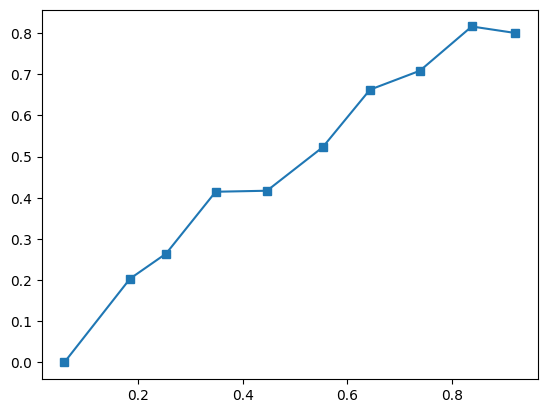

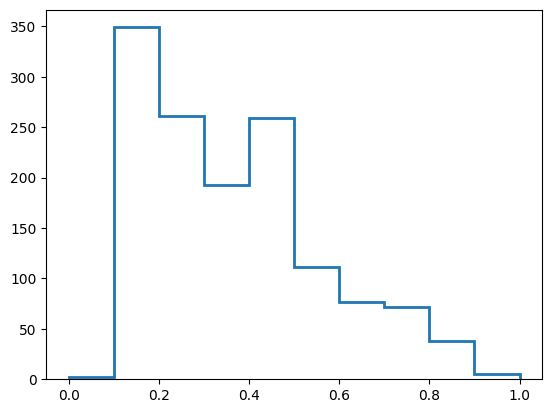

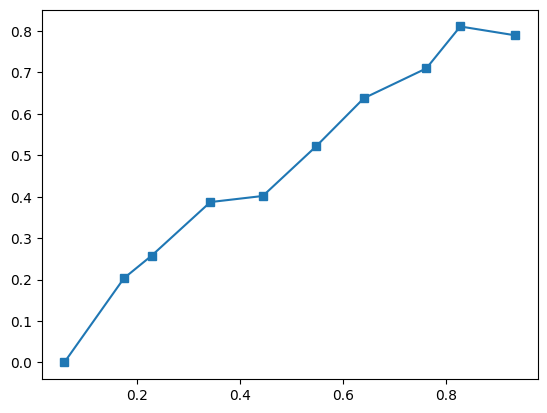

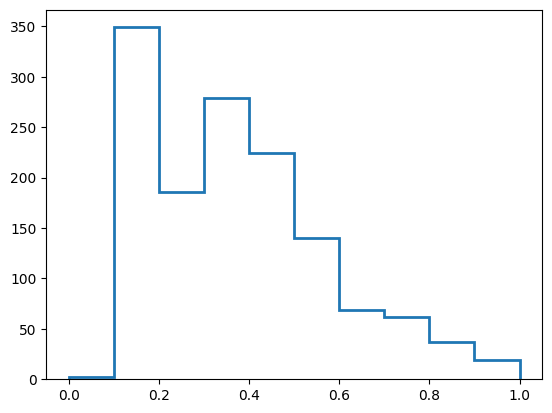

| Step 5 ==> Fit clinical score calculator
Fit clincal score calculator
Threshold:0.1
31

Threshold:0.5
38

Threshold:0.9
44

ROC AUC: 0.6695422870243674
Average Precision: 0.535960040050284


In [22]:
from pygam import s, f

equation = s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + f(7) + f(8) + f(9)

explainer = classic_explainer(X_train, y_train, X_test, y_test)

# ----------- Move this to medical_explainer_classic_
from sklearn.model_selection import StratifiedKFold

print('| Step 1 ==> Selecting top n features')
explainer.selected_features = selected_features

print('| Step 2 ==> Transforming features based on GAM')
explainer.find_features_categories_gam(equation)

print('| Step 3 ==> Fitting logistic regression model on transformed categories')
explainer.fit_logreg()

print('| Step 4 ==> Calibrating logistic regression model')

skf = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

explainer.plot_calibration_original()
explainer.calibrate(cv=skf)
explainer.plot_calibration_calibrated()

print('| Step 5 ==> Fit clinical score calculator')
explainer.fit_calculator()
# ----------- Move this to medical_explainer_classic_

_, probs, _ = explainer.predict_calculator(X_test, 1)

performance(y_test, probs)

##2. RiskSLIM

In [34]:
y_train = y_train.reset_index(drop=True)
top_n = 10
scaler = MinMaxScaler()
kbest = SelectKBest(chi2, k=top_n)
scaler.fit(X_train)

X_train = kbest.fit_transform(scaler.transform(X_train), y_train)
X_test = kbest.transform(scaler.transform(X_test))

X_train = pd.DataFrame(X_train, columns=X.columns[kbest.get_support()])
X_test = pd.DataFrame(X_test, columns=X.columns[kbest.get_support()])

X_train.insert(0, '28 Day Death', y_train)
X_train.to_csv('data_train.csv', index=False)

sample_weights_csv_file = None                              # csv file of sample weights for the dataset (optional)

# problem parameters
max_coefficient = 5                                         # value of largest/smallest coefficient
max_L0_value = 5                                            # maximum model size (set as float(inf))
max_offset = 50                                             # maximum value of offset parameter (optional)
c0_value = 1e-6                                             # L0-penalty parameter such that c0_value > 0; larger values -> sparser models; we set to a small value (1e-6) so that we get a model with      max_L0_value terms

In [35]:
data_csv_file = 'data_train.csv'

# load data from disk
data = riskslim.load_data_from_csv(dataset_csv_file = data_csv_file, sample_weights_csv_file = sample_weights_csv_file)

# create coefficient set and set the value of the offset parameter
coef_set = riskslim.CoefficientSet(variable_names = data['variable_names'], lb = -max_coefficient, ub = max_coefficient, sign = 0)
coef_set.update_intercept_bounds(X = data['X'], y = data['Y'], max_offset = max_offset)

constraints = {
    'L0_min': 0,
    'L0_max': max_L0_value,
    'coef_set':coef_set,
}
 
# major settings (see riskslim_ex_02_complete for full set of options)
settings = {
    # Problem Parameters
    'c0_value': c0_value,
    #
    # LCPA Settings
    'max_runtime': 30.0,                               # max runtime for LCPA
    'max_tolerance': np.finfo('float').eps,             # tolerance to stop LCPA (set to 0 to return provably optimal solution)
    'display_cplex_progress': True,                     # print CPLEX progress on screen
    'loss_computation': 'fast',                         # how to compute the loss function ('normal','fast','lookup')
    #
    # LCPA Improvements
    'round_flag': True,                                # round continuous solutions with SeqRd
    'polish_flag': True,                               # polish integer feasible solutions with DCD
    'chained_updates_flag': True,                      # use chained updates
    'add_cuts_at_heuristic_solutions': True,            # add cuts at integer feasible solutions found using polishing/rounding
    #
    # Initialization
    'initialization_flag': True,                       # use initialization procedure
    'init_max_runtime': 120.0,                         # max time to run CPA in initialization procedure
    'init_max_coefficient_gap': 0.49,
    #
    # CPLEX Solver Parameters
    'cplex_randomseed': 0,                              # random seed
    'cplex_mipemphasis': 0,                             # cplex MIP strategy
}

# train model using lattice_cpa
model_info, mip_info, lcpa_info = riskslim.run_lattice_cpa(data, constraints, settings)

#print model contains model
riskslim.print_model(model_info['solution'], data)


def predict_df(X, rho):
    rho_values = np.copy(rho)
    
    if len(rho) > len(X.columns):
        intercept = rho[0]
        rho_values = np.delete(rho_values, 0)
    else:
        intercept = 0
        
    scores = np.dot(X.values, rho_values)
    probs = 1/(1+np.exp(-(intercept + scores)))
    predictions = (probs >= 0.5).astype(int)
    
    return scores, probs, predictions

_, probs, _ = predict_df(X_test, model_info['solution'])
performance(y_test, probs)

setting c0_value = 0.0 for (Intercept) to ensure that intercept is not penalized
04/25/23 @ 08:22 AM | switching loss computation from fast to weighted
04/25/23 @ 08:22 AM | ------------------------------------------------------------
04/25/23 @ 08:22 AM | runnning initialization procedure
04/25/23 @ 08:22 AM | ------------------------------------------------------------
04/25/23 @ 08:22 AM | CPA produced 2 cuts
04/25/23 @ 08:22 AM | running naive rounding on 3 solutions
04/25/23 @ 08:22 AM | best objective value: 0.6931
04/25/23 @ 08:22 AM | rounding produced 3 integer solutions
04/25/23 @ 08:22 AM | best objective value is 0.6931
04/25/23 @ 08:22 AM | running sequential rounding on 3 solutions
04/25/23 @ 08:22 AM | best objective value: 0.6931
04/25/23 @ 08:22 AM | sequential rounding produced 1 integer solutions
04/25/23 @ 08:22 AM | best objective value: 0.6931
04/25/23 @ 08:22 AM | polishing 4 solutions
04/25/23 @ 08:22 AM | best objective value: 0.6931
04/25/23 @ 08:22 AM | polis

Lazy constraint(s) or lazy constraint/branch callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling presolve reductions that prevent crushing forms (CPX_PARAM_PREREFORM).
         Disabling repeat represolve because of lazy constraint/incumbent callback.
Tried aggregator 1 time.
Reduced MIP has 22 rows, 24 columns, and 63 nonzeros.
Reduced MIP has 10 binaries, 12 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.03 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.03 ticks)
04/25/23 @ 08:22 AM | adding 131 initial cuts

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variable B NodeID Parent  Depth

      0     0        0.5639    18                      0.5639  

In [36]:
X = df.drop(columns = ['28 Day Death', 'In Hospital Death'])
y = df['28 Day Death']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=seed)


imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X_train)

X_train = pd.DataFrame(imp.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(imp.transform(X_test), columns=X.columns)

##3. Logistic Regression 

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

estimators = [('Scaler', StandardScaler()), ('Log_Reg', LogisticRegression(random_state=seed, solver='liblinear'))]
pipe = Pipeline(estimators)

clf = pipe.fit(X_train, y_train)

| Step 1  ==> Calibrating model


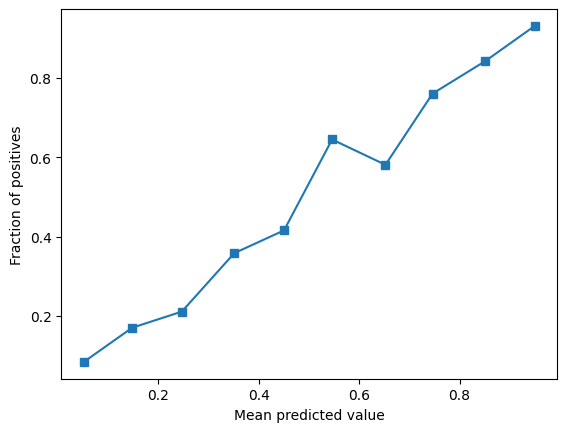

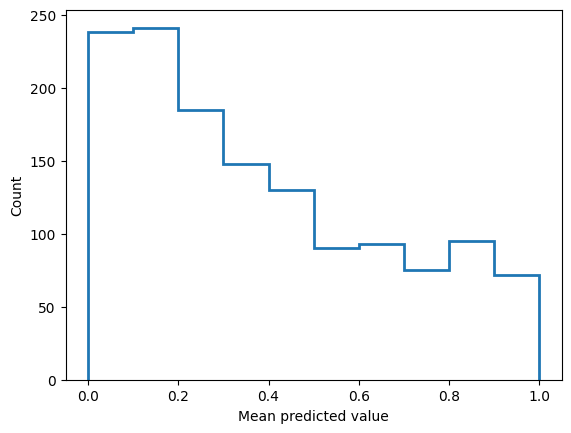

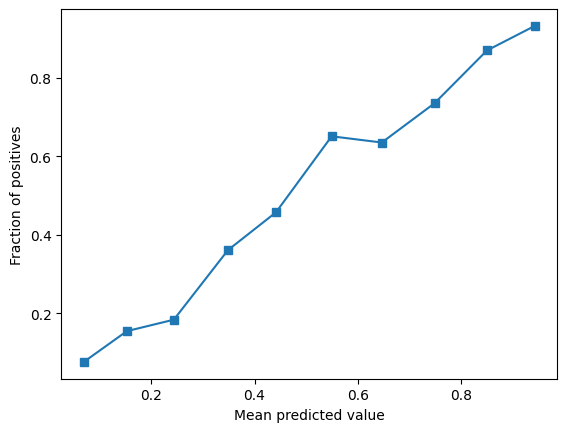

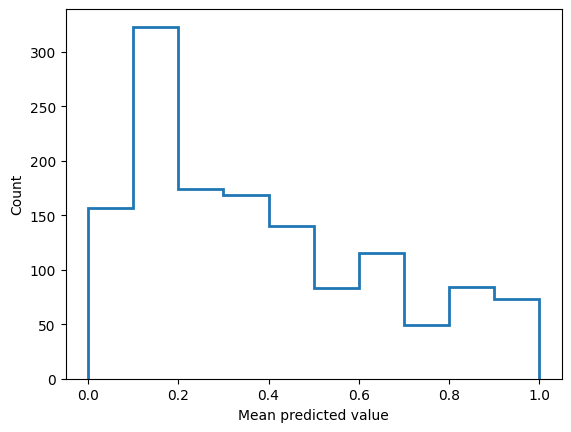

ROC AUC: 0.8157730193107574
Average Precision: 0.753868020157545
Accuracy: 0.7688368690563278
ROC AUC: 0.8177462325446518
Average Precision: 0.7562388064653908
Accuracy: 0.7666422823701536

| Step 2 ==> Calculate SHAP values

| Step 3 ==> Fit clinical score calculator
Novel fitting


Probability threshold: 0.1
Score threshold: 10.0

Probability threshold: 0.5
Score threshold: 22.0

Probability threshold: 0.9
Score threshold: 34.0

ROC AUC: 0.6929773091805389
Average Precision: 0.5628664533727118


In [35]:
explainer = medical_explainer['explainer'](clf, X_train, y_train, X_test, y_test)

explainer.fit(10, shap_method='linear', method='novel')
scores, probs, _ = explainer.predict_calculator(X_test, 1)

performance(y_test, probs)

In [44]:
features = np.argpartition(np.abs(clf[1].coef_), -2)[0][-2:]

print(clf[1].coef_[0][features])

# PartialDependenceDisplay.from_estimator(clf, X_test, features)

print(np.corrcoef(scores, X_test.iloc[:, features[0]]))
print(np.corrcoef(scores, X_test.iloc[:, features[1]]))

[ 0.5293558  -0.99650451]
[[1.         0.10565743]
 [0.10565743 1.        ]]
[[ 1.         -0.24105916]
 [-0.24105916  1.        ]]


##4. Gradient Boosting

In [40]:
from sklearn.ensemble import GradientBoostingClassifier

parameters = {
    'n_estimators': [160, 180, 200, 220], 
    'max_depth':[1, 3, 5]
}

GBoost = GradientBoostingClassifier(random_state=seed)
clf = GridSearchCV(GBoost, parameters, scoring='roc_auc')
clf.fit(X_train, y_train)

print(clf.best_params_)
print(clf.best_score_)

{'max_depth': 3, 'n_estimators': 200}
0.8520637254044399


In [10]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=200, max_depth=7, random_state=seed).fit(X_train, y_train)
clf.fit(X_train, y_train)

y_pred = clf.predict_proba(X_test)[:, 1]

performance(y_test, y_pred)

ROC AUC: 0.8656697144617725
Average Precision: 0.8215252955478871


| Step 1  ==> Calibrating model


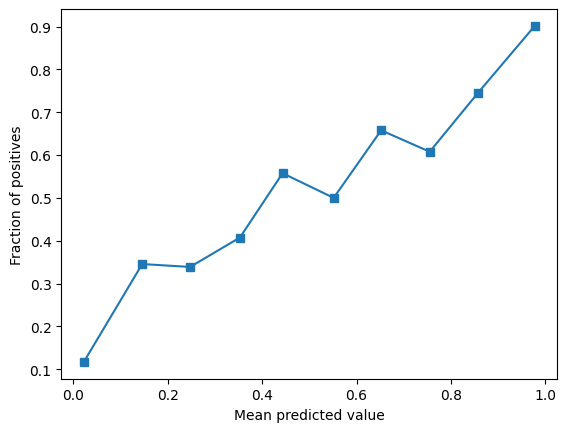

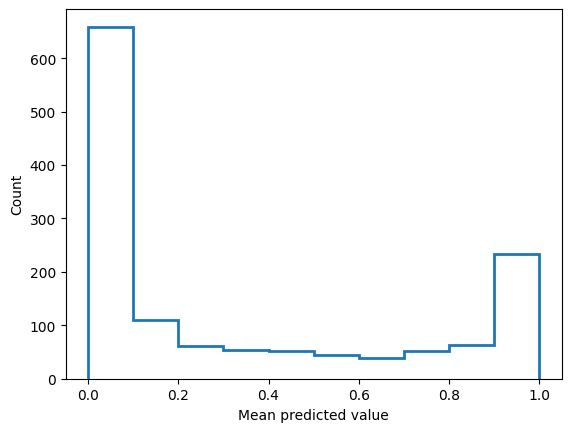

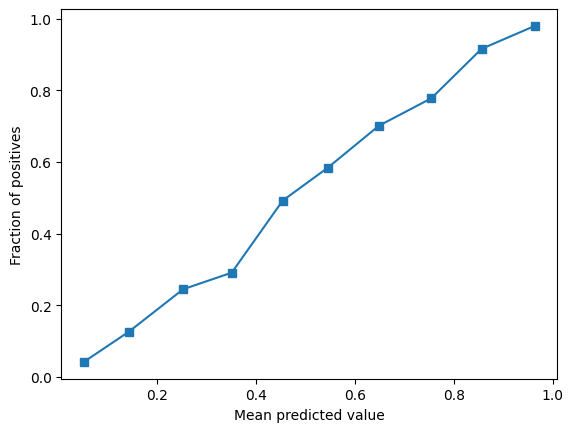

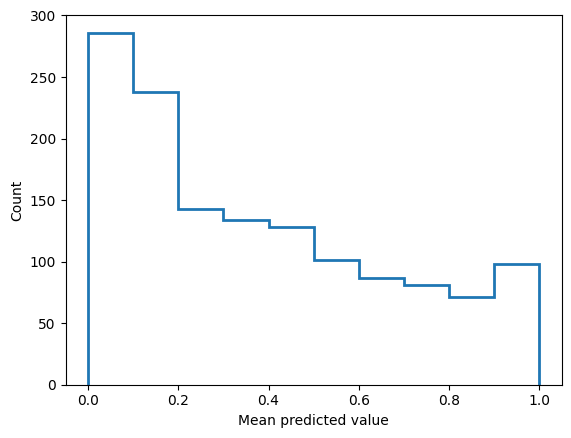

ROC AUC: 0.8656697144617725
Average Precision: 0.8215252955478871
Accuracy: 0.7944403803950256
ROC AUC: 0.8740904189283482
Average Precision: 0.8310165851100977
Accuracy: 0.8002926115581566

| Step 2 ==> Calculate SHAP values

| Step 3 ==> Fit clinical score calculator
Novel fitting


Probability threshold: 0.1
Score threshold: 17.0

Probability threshold: 0.5
Score threshold: 29.0

Probability threshold: 0.9
Score threshold: 42.0

ROC AUC: 0.7369339755149383
Average Precision: 0.6331902854906984


In [11]:
explainer = medical_explainer['explainer'](clf, X_train, y_train, X_test, y_test)

explainer.fit(10, shap_method='tree', method='novel', calculator_threshold=0.0001)
scores, probs, _ = explainer.predict_calculator(X_test, 1)

performance(y_test, probs)

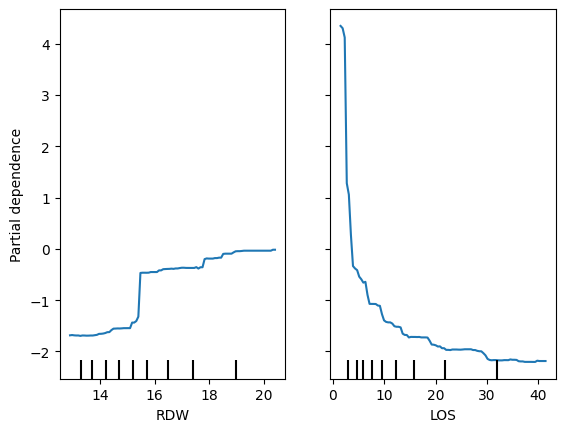

In [17]:
features = np.argpartition(clf.feature_importances_, -2)[-2:]

PartialDependenceDisplay.from_estimator(clf, X_test, features)

In [22]:
np.corrcoef(scores, X_test.iloc[:, features[0]])

array([[1.        , 0.40844453],
       [0.40844453, 1.        ]])

In [23]:
np.corrcoef(scores, X_test.iloc[:, features[1]])

array([[ 1.        , -0.16805642],
       [-0.16805642,  1.        ]])

##5. Random Forest

In [37]:
from sklearn.ensemble import RandomForestClassifier

parameters = {
    'n_estimators': [220, 240, 260, 300, 340], 
    'max_depth':[1, 3, 5]
}

RanFor = RandomForestClassifier(n_estimators=110, max_depth=7, random_state=seed)
clf = GridSearchCV(RanFor, parameters, scoring='roc_auc')
clf.fit(X_train, y_train)

print(clf.best_params_)
print(clf.best_score_)

{'max_depth': 5, 'n_estimators': 340}
0.8062603023019618


In [24]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=340, max_depth=5, random_state=seed)
clf.fit(X_train, y_train)

y_pred = clf.predict_proba(X_test)[:, 1]

performance(y_test, y_pred)

ROC AUC: 0.8179433273223201
Average Precision: 0.7507287750555357


| Step 1  ==> Calibrating model


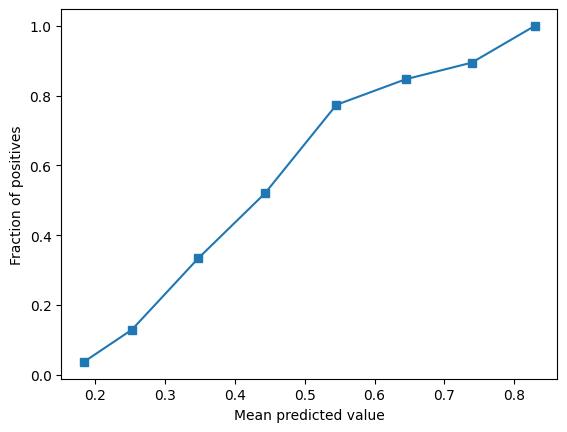

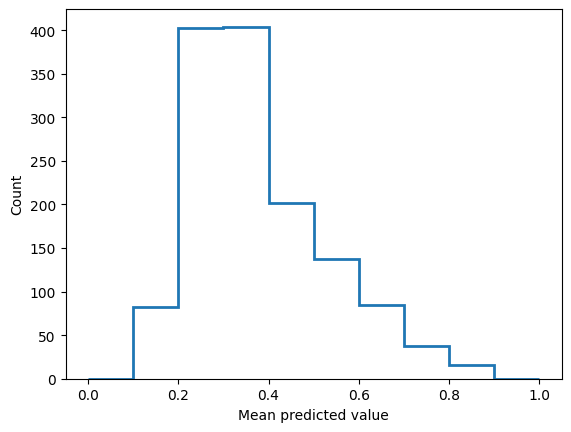

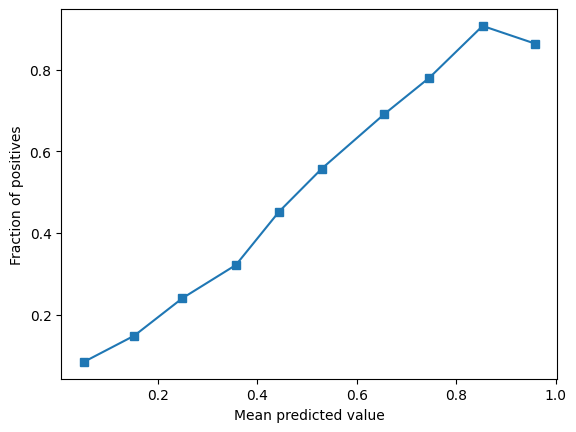

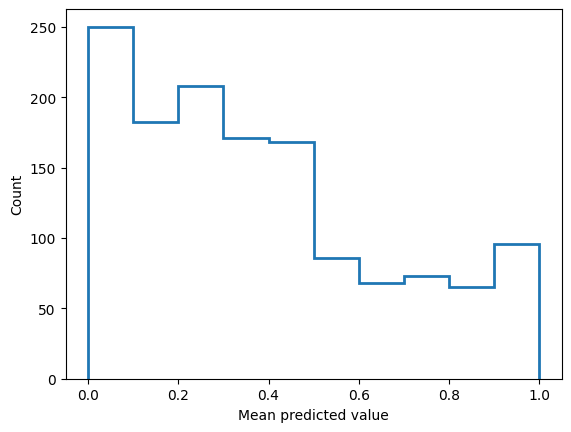

ROC AUC: 0.8179433273223201
Average Precision: 0.7507287750555357
Accuracy: 0.7490855888807608
ROC AUC: 0.819202921533624
Average Precision: 0.7511960897335462
Accuracy: 0.7637161667885881

| Step 2 ==> Calculate SHAP values

| Step 3 ==> Fit clinical score calculator
Novel fitting


Probability threshold: 0.1
Score threshold: nan

Probability threshold: 0.5
Score threshold: 34.0

Probability threshold: 0.9
Score threshold: 48.0

ROC AUC: 0.7456480566908013
Average Precision: 0.660230951450847


In [25]:
explainer = medical_explainer['explainer'](clf, X_train, y_train, X_test, y_test)

explainer.fit(10, shap_method='tree', method='novel', calculator_threshold=0.0001)
scores, probs, _ = explainer.predict_calculator(X_test, 1)

performance(y_test, probs)

[[1.        0.5046389]
 [0.5046389 1.       ]]
[[ 1.         -0.04904681]
 [-0.04904681  1.        ]]


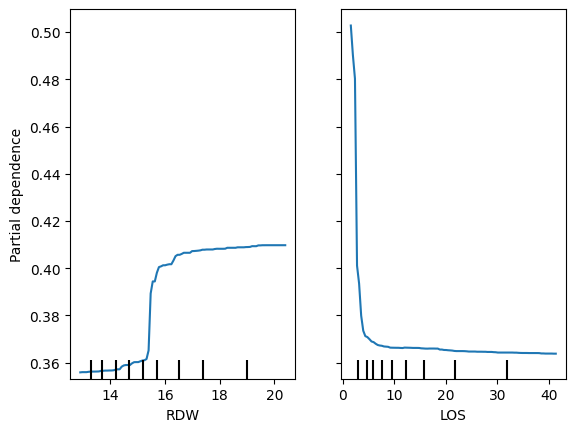

In [26]:
features = np.argpartition(clf.feature_importances_, -2)[-2:]

PartialDependenceDisplay.from_estimator(clf, X_test, features)

print(np.corrcoef(scores, X_test.iloc[:, features[0]]))
print(np.corrcoef(scores, X_test.iloc[:, features[1]]))

##6. Neural Network

In [103]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

estimators = [('Scaler', StandardScaler()), 
              ('Neural_Network', MLPClassifier(
                  hidden_layer_sizes=(100),
                  random_state=seed, 
                  activation='logistic', 
                  solver='sgd', 
                  max_iter=1000))]
pipe = Pipeline(estimators)

pipe.fit(X_train, y_train)

y_pred = pipe.predict_proba(X_test)[:, 1]

performance(y_test, y_pred)

ROC AUC: 0.8100482089295262
Average Precision: 0.740140126570731


| Step 1  ==> Calibrating model


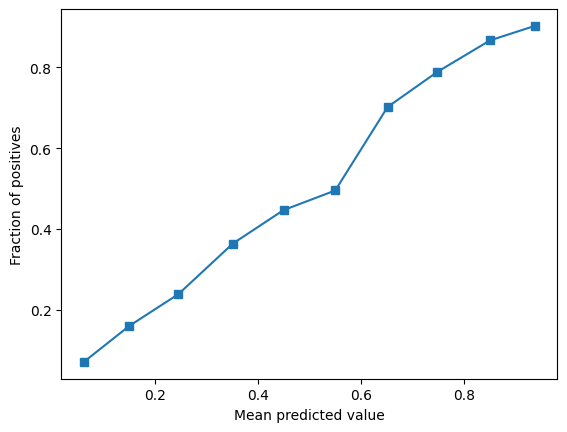

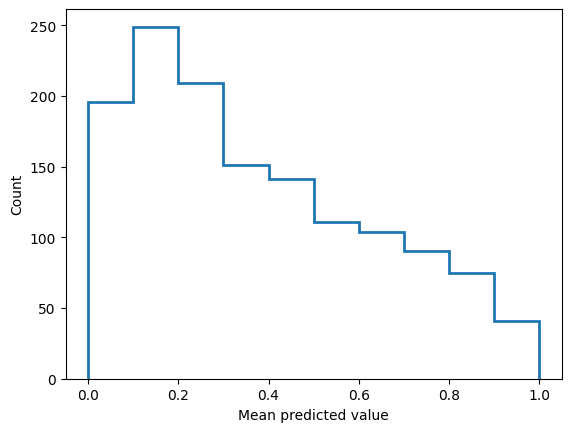

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.


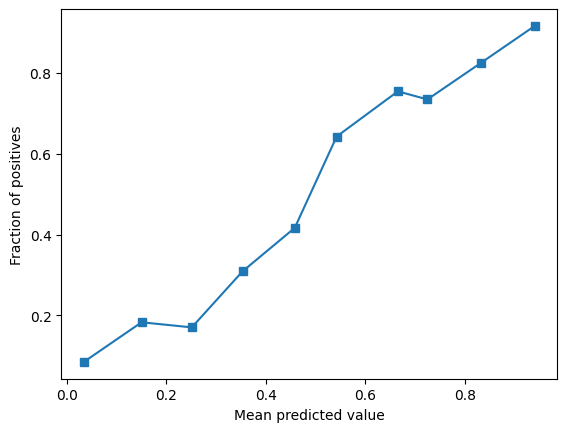

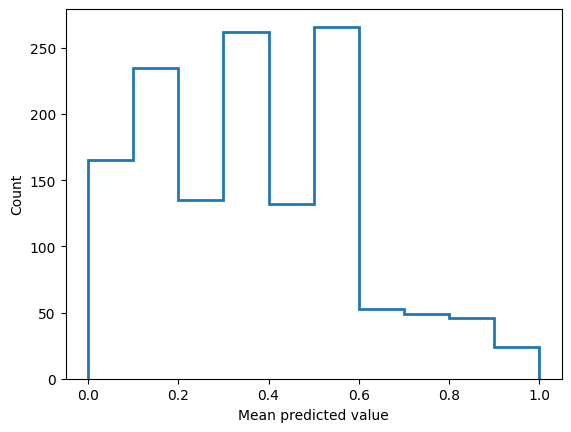

ROC AUC: 0.8100482089295262
Average Precision: 0.740140126570731
Accuracy: 0.7498171177761521
ROC AUC: 0.7866800177611846
Average Precision: 0.692858450517027
Accuracy: 0.7461594732991953

| Step 2 ==> Calculate SHAP values


Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.


Kernel Explainer Iteration 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Kernel Explainer Iteration 1


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
explainer = medical_explainer['explainer'](pipe, X_train[:1000], y_train[:1000], X_test, y_test)
explainer.fit(10, shap_method='kernel', method='novel', n_splits=2)

In [106]:
_, probs, _ = explainer.predict_calculator(X_test, 1)

performance(y_test, probs)

ROC AUC: 0.5192779081674262
Average Precision: 0.3985238436376116


##7. LightGBM (ablations)

In [52]:
import re
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [53]:
from lightgbm import LGBMClassifier


parameters = {
    'n_estimators': [160, 180, 200, 220], 
    'max_depth':[1, 3, 5]
}

lgbm = LGBMClassifier(random_state=seed)
clf = GridSearchCV(lgbm, parameters, scoring='roc_auc')
clf.fit(X_train, y_train)

print(clf.best_params_)
print(clf.best_score_)

{'max_depth': 3, 'n_estimators': 160}
0.8490602559401597


In [76]:
# Need to do some tuning
clf = LGBMClassifier(n_estimators=160, max_depth=3, random_state=seed)
clf.fit(X_train, y_train)

y_pred = clf.predict_proba(X_test)[:, 1]

performance(y_test, y_pred)

ROC AUC: 0.878872799108316
Average Precision: 0.8375045288951812


| Step 1  ==> Calibrating model


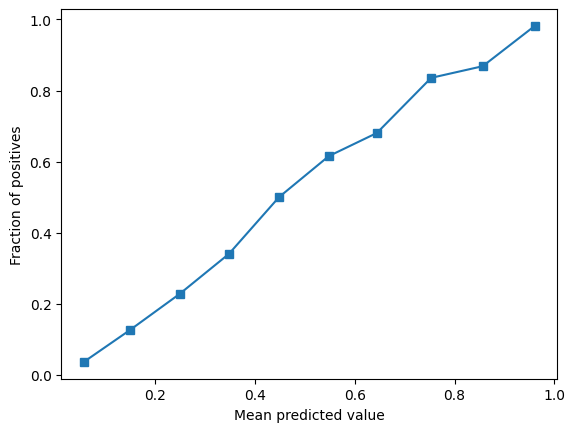

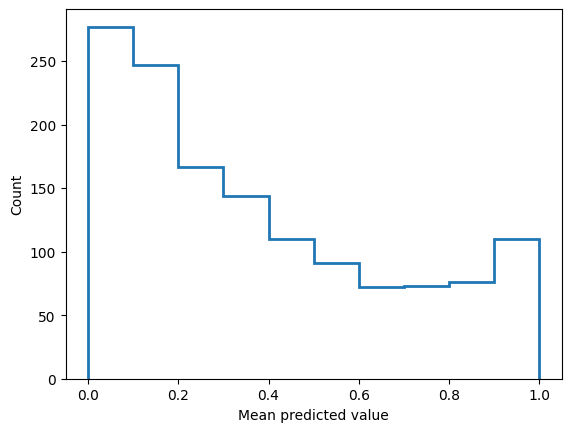

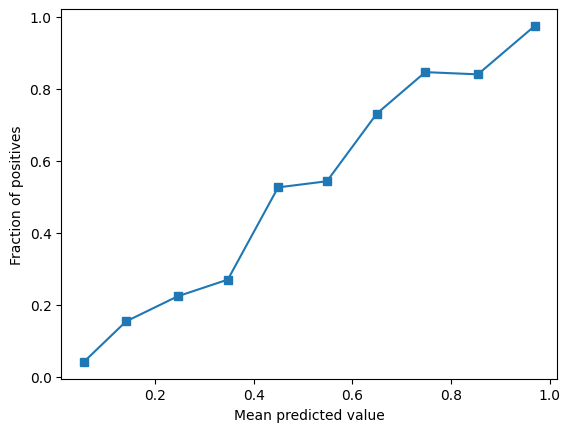

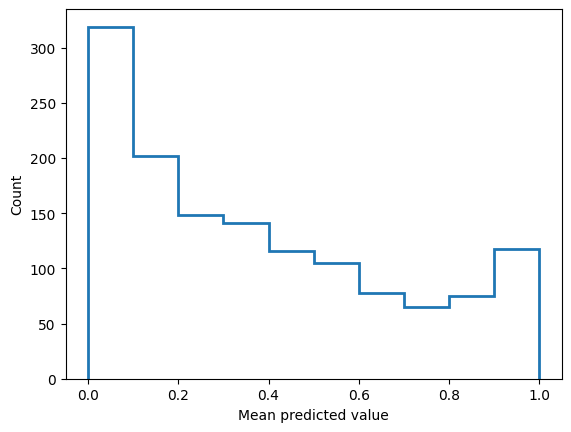

ROC AUC: 0.878872799108316
Average Precision: 0.8375045288951812
Accuracy: 0.8061448427212875
ROC AUC: 0.8766707746957489
Average Precision: 0.8359134769445319
Accuracy: 0.8024871982443307

| Step 2 ==> Calculate SHAP values


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


2
nan
[[-0.84186946 -0.6153111  -0.46554742 ... -0.63178804 -0.94754225
  -0.66497638]
 [-0.53284693 -0.6153111  -0.77823725 ... -0.63450585 -0.84955321
  -0.69557832]
 [-0.15916181 -0.6153111  -1.19191621 ... -0.62496746 -0.93495128
  -0.69200209]
 ...
 [-1.32855522 -0.6153111  -0.76541329 ... -0.6439432  -0.94163929
  -0.69832852]
 [-1.1276053  -0.6153111  -1.04452989 ... -0.63772107 -0.46376915
  -0.68730154]
 [-0.46177443 -0.6153111  -0.9505236  ... -0.62610786 -0.55390098
  -0.6932121 ]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])]


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


2
nan
[[-0.68569887 -0.61779217 -0.43331863 ... -0.62860045 -0.92782589
  -0.66835543]
 [-0.59915754 -0.61779217 -0.86645959 ... -0.62784471 -0.86783912
  -0.68849495]
 [-0.0142919  -0.61779217 -1.08896641 ... -0.621944   -0.90095054
  -0.67020329]
 ...
 [-1.38488275 -0.61779217 -0.9444064  ... -0.62852539 -0.90544575
  -0.72709958]
 [-1.11817795 -0.61779217 -1.03473841 ... -0.62921703 -0.50376767
  -0.7237253 ]
 [-0.30734183 -0.61779217 -0.88777371 ... -0.62848041 -0.58587735
  -0.69404238]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]]), array([[nan, nan, nan, ..., nan

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


2
nan
[[-0.57989698 -0.62378892 -0.59681942 ... -0.65424779 -0.91311047
  -0.66815684]
 [-0.5448605  -0.62378892 -0.87773379 ... -0.65207534 -0.95104711
  -0.69261114]
 [-0.11410452 -0.62378892 -0.99388126 ... -0.65035144 -0.95421332
  -0.69298411]
 ...
 [-1.33883788 -0.62378892 -0.91510142 ... -0.65507864 -0.96049665
  -0.75335549]
 [-1.22008191 -0.62378892 -1.00503003 ... -0.62226055 -0.51918962
  -0.7059035 ]
 [-0.27638183 -0.62378892 -0.87716937 ... -0.65571757 -0.57076678
  -0.74336996]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]]), array([[nan, nan, nan, ..., nan

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


2
nan
[[-0.59845012 -0.61966301 -0.49484258 ... -0.63229406 -0.96808533
  -0.65237142]
 [-0.52266303 -0.61966301 -0.80392703 ... -0.62921483 -0.92899879
  -0.65694727]
 [ 0.0154947  -0.61966301 -0.95095997 ... -0.62968794 -1.0102261
  -0.66070741]
 ...
 [-1.47505682 -0.61966301 -0.87135029 ... -0.6353092  -0.86493874
  -0.72850559]
 [-1.42131678 -0.61966301 -1.00189308 ... -0.63491528 -0.45020638
  -0.70891522]
 [-0.3708638  -0.61966301 -0.88302062 ... -0.63080283 -0.47759269
  -0.6749653 ]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]]), array([[nan, nan, nan, ..., nan,

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


ValueError: ignored

In [102]:
explainer = test_explainer(clf, X_train, y_train, X_test, y_test)

explainer.fit(10, shap_method='tree', method='novel', calculator_threshold=0.000001)
_, probs, _ = explainer.predict_calculator(X_test, 1)

performance(y_test, probs)

##8. CatBoost

In [56]:
# Need to do some tuning
from catboost import CatBoostClassifier

clf = CatBoostClassifier(iterations=2,
                           depth=2,
                           learning_rate=1,
                           loss_function='Logloss',
                           verbose=True)

clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)[:, 1]

performance(y_test, y_pred)

0:	learn: 0.5900003	total: 4.82ms	remaining: 4.82ms
1:	learn: 0.5477695	total: 9.11ms	remaining: 0us
ROC AUC: 0.7433995904053355
Average Precision: 0.6499583582876234


| Step 1  ==> Calibrating model


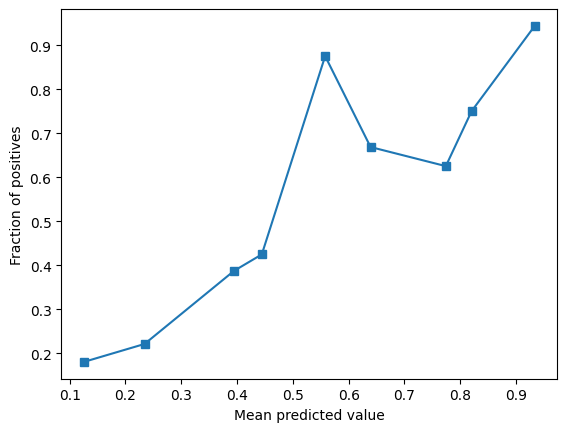

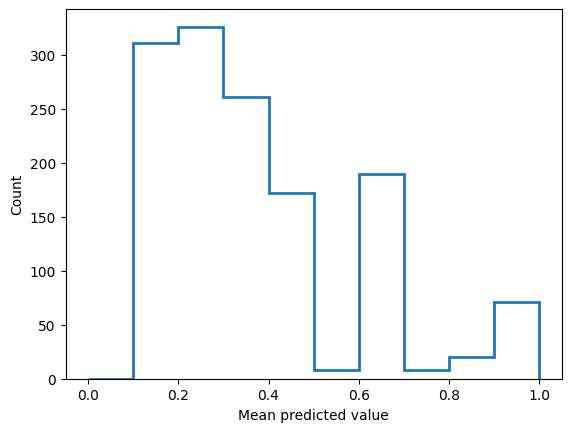

0:	learn: 0.5917813	total: 4.62ms	remaining: 4.62ms
1:	learn: 0.5513174	total: 10.3ms	remaining: 0us
0:	learn: 0.5873018	total: 5.28ms	remaining: 5.28ms
1:	learn: 0.5512446	total: 10.6ms	remaining: 0us
0:	learn: 0.5914841	total: 9.31ms	remaining: 9.31ms
1:	learn: 0.5564509	total: 17.1ms	remaining: 0us
0:	learn: 0.5868637	total: 9.83ms	remaining: 9.83ms
1:	learn: 0.5467445	total: 18.1ms	remaining: 0us
0:	learn: 0.5888076	total: 6.93ms	remaining: 6.93ms
1:	learn: 0.5479018	total: 13.6ms	remaining: 0us


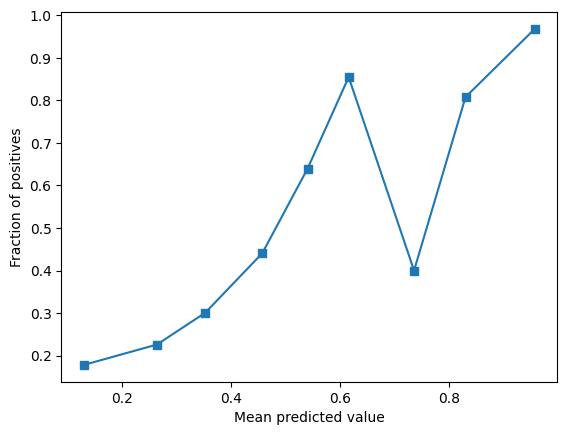

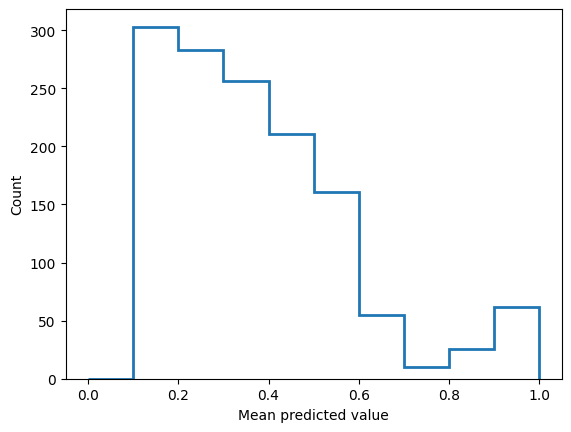

ROC AUC: 0.7433995904053355
Average Precision: 0.6499583582876234
Accuracy: 0.723482077542063
ROC AUC: 0.7516945619965021
Average Precision: 0.6905651116982187
Accuracy: 0.731528895391368

| Step 2 ==> Calculate SHAP values

| Step 3 ==> Fit clinical score calculator
Novel fitting


ValueError: ignored

In [57]:
explainer = medical_explainer['explainer'](clf, X_train, y_train, X_test, y_test)

explainer.fit(10, shap_method='tree', method='novel', calculator_threshold=0.0001)
_, probs, _ = explainer.predict_calculator(X_test, 1)

performance(y_test, probs)

#References

> Anthony Li, Ming Lun Ong, Chien Wei Oei, Weixiang
Lian, Hwee Pin Phua, Lin Htun Htet, and Wei Yen
Lim. 2022. Unified auto clinical scoring (Uni-ACS)
with interpretable ml models. In Machine Learning
for Healthcare Conference, pages 26–53. PMLR.


